In [17]:
%%capture
import sys; sys.path.append('../../..')

# Requires alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats ta-lib (also requires talib C install)
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import backtrader as bt
import matplotlib as mpl
import pytz
import datetime
from functools import lru_cache

import datetime

mpl.rcParams['figure.dpi'] = 250


API_KEY: str = ""
SECRET_KEY: str = ""
for l in open('../../../paper.env'):
    if l.startswith("APCA_API_KEY_ID="):
        API_KEY = l.split("=")[1].strip()
    elif l.startswith("APCA_API_SECRET_KEY="):
        SECRET_KEY = l.split("=")[1].strip()

assert API_KEY
assert SECRET_KEY

rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')



def get_pandas_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")

  if timeframe != TimeFrame.Day:
    alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)

  return alpaca_data

@lru_cache()
def get_data(symbol, timeframe, start, end):
  alpaca_data = get_pandas_data(symbol, timeframe, start, end)
  data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol, tz=pytz.timezone('US/Eastern'))
  return data

def run_backtest(strategy, symbol: str, start: str, end: str, params, timeframe=TimeFrame.Minute, cash=10000):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
  cerebro.adddata(get_data(symbol, timeframe, start, end))
 
  results = cerebro.run()

  cerebro.plot(iplot=True)

  strat = results[0]
  return strat

def get_roi(strategy):
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  r = 1
  for ret in annual_returns.values():
    r *= 1 + ret
  r -= 1
  return r

def get_max_drawdown(strategy):
  return strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100



In [52]:
class MyStrategy(bt.Strategy):
    params = dict(
      ema_period=200,
      rsi_period=14,
      rsi_entry_level=30,
      rsi_exit_level=40,
    )

    def __init__(self):
      self.rsi = bt.ind.RSI(period=self.p.rsi_period)
      self.ema = bt.ind.EMA(period=self.p.ema_period)
      # self.buy_signal = bt.And(self.data.close > self.ema, self.rsi.rsi < self.p.rsi_entry_level)
      self.buy_signal = self.rsi.rsi < self.p.rsi_entry_level
      self.stay_signal = self.rsi.rsi < self.p.rsi_exit_level

    def next(self):
      if not self.position and self.buy_signal:
        self.order_target_size(target=1)
      if self.position and self.stay_signal:
        self.order_target_size(target=1)
      elif self.position and not self.stay_signal:
        self.order_target_size(target=0)
      else:
        self.order_target_size(target=0)


In [53]:
symbol = 'SPY'
start = "2010-01-01"
end = "2022-05-19"
cash = 500
timeframe = TimeFrame.Day

# Detail

<IPython.core.display.Javascript object>

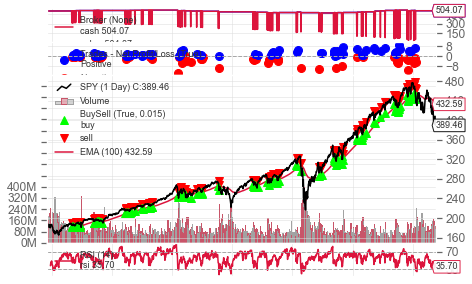

In [46]:
strategy = run_backtest(MyStrategy, symbol, start, end,
  {'ema_period': 100, 'rsi_period': 14, 'rsi_entry_level': 50, 'rsi_exit_level': 30}
  , cash=cash, timeframe=timeframe
)

In [47]:
annual_returns = strategy.analyzers.annualreturn.get_analysis()
analysis = strategy.analyzers.tradeanalyzer.get_analysis()
# print(strategy.p.__dict__)
print(f"ROI     : {get_roi(strategy):.1%}")
print(f"Drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100:.1%}")
print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")

ROI     : 0.8%
Drawdown: 10.3%
Average : 128 trades @ 0.03
Winners : 54.7% @ 2.35
Losers  : 45.3% @ -2.76


In [48]:
import quantstats
portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
quantstats.reports.basic(returns)

                    Strategy
------------------  ----------
Start Period        2015-12-01
End Period          2022-05-19
Risk-Free Rate      0.0%
Time in Market      16.0%

Cumulative Return   0.81%
CAGR﹪              0.13%

Sharpe              0.06
Sortino             0.07
Sortino/√2          0.05
Omega               1.03

Max Drawdown        -10.27%
Longest DD Days     1730

Gain/Pain Ratio     0.03
Gain/Pain (1M)      0.07

Payoff Ratio        0.85
Profit Factor       1.03
Common Sense Ratio  2.25
CPC Index           0.48
Tail Ratio          2.19
Outlier Win Ratio   23.57
Outlier Loss Ratio  2.26

MTD                 0.0%
3M                  0.0%
6M                  -2.33%
YTD                 -0.89%
1Y                  2.07%
3Y (ann.)           1.62%
5Y (ann.)           -0.31%
10Y (ann.)          0.13%
All-time (ann.)     0.13%

Avg. Drawdown       -1.06%
Avg. Drawdown Days  180
Recovery Factor     0.08
Ulcer Index         0.05
Serenity Index      0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
from src.results import metadata, from_backtest
from src import types

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

from_backtest.write_results("chipdip", [types.FilledOrder(intention=None, symbol=t['symbol'], quantity=t['amount'], price=t['price'], datetime=t['time'].to_pydatetime()) for t in transactions.to_dict('records')], metadata.Metadata(commit_id="", last_updated=datetime.datetime.now()))

# Optimize

In [54]:
gridsearch = dict(
    # ema_period=[50, 100, 200, 250],
    # TODO: try parsar instead of 200ema
    rsi_entry_level=[20, 30, 40, 50],
    rsi_exit_level=[30, 40, 50, 60],
    rsi_period=[5, 9, 14],
)

time_per = datetime.timedelta(seconds=.5)

choices = 1
for l in gridsearch.values():
  choices *= len(l)

estimated_time = time_per * choices
print(f"Estimated time (@ {time_per}, {choices}): {estimated_time}")
start_time = datetime.datetime.now()
print(f"(ending at {start_time + (time_per * choices)})")
print("=" * 80)

cerebro = bt.Cerebro(stdstats=True, maxcpus=1)  # inside of VS Code editor, this does not go well
cerebro.broker.setcash(cash)
cerebro.optstrategy(MyStrategy, **gridsearch)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
cerebro.adddata(get_data(symbol, timeframe, start, end))

runs = cerebro.run()
backtest_results = [results[0] for results in runs]



end_time = datetime.datetime.now()
print(f"Done. Took {end_time - start_time}")
print(f"time per: {(end_time - start_time) / choices}")

for strategy in list(sorted(backtest_results, key=get_roi, reverse=True))[:10]:
  analysis = strategy.analyzers.tradeanalyzer.get_analysis()
  if analysis["total"]["total"] == 0:
    continue
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  print(strategy.p.__dict__)
  print(f"ROI     : {get_roi(strategy):.1%}")
  print(f"Drawdown: {get_max_drawdown(strategy):.1%}")
  print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
  print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
  print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")
  print()

Estimated time (@ 0:00:00.500000, 48): 0:00:24
(ending at 2022-05-20 12:35:44.119642)
Done. Took 0:00:23.573643
time per: 0:00:00.491118
{'ema_period': 200, 'rsi_period': 5, 'rsi_entry_level': 50, 'rsi_exit_level': 50}
ROI     : 22.2%
Drawdown: 16.1%
Average : 132 trades @ 0.84
Winners : 72.7% @ 3.15
Losers  : 26.5% @ -5.49

{'ema_period': 200, 'rsi_period': 14, 'rsi_entry_level': 50, 'rsi_exit_level': 60}
ROI     : 16.7%
Drawdown: 18.0%
Average : 28 trades @ 5.08
Winners : 82.1% @ 8.96
Losers  : 14.3% @ -17.18

{'ema_period': 200, 'rsi_period': 9, 'rsi_entry_level': 50, 'rsi_exit_level': 60}
ROI     : 16.7%
Drawdown: 16.6%
Average : 45 trades @ 3.17
Winners : 84.4% @ 6.03
Losers  : 13.3% @ -14.94

{'ema_period': 200, 'rsi_period': 14, 'rsi_entry_level': 40, 'rsi_exit_level': 60}
ROI     : 15.0%
Drawdown: 17.1%
Average : 16 trades @ 7.27
Winners : 75.0% @ 13.21
Losers  : 18.8% @ -16.49

{'ema_period': 200, 'rsi_period': 5, 'rsi_entry_level': 50, 'rsi_exit_level': 40}
ROI     : 13.8%
Dr